# Cloning CORDS repository

In [1]:
"""
!git clone https://github.com/decile-team/cords.git
%cd cords/
%ls
"""

'\n!git clone https://github.com/decile-team/cords.git\n%cd cords/\n%ls\n'

In [2]:
import sys
print(sys.executable)

/Users/abdullahsalihozguven/Desktop/CS 436 - Final Project/cords/cords-env/bin/python3


In [3]:
import PIL
import PIL.Image
print(PIL.__version__)
print(hasattr(PIL.Image, "Resampling"))


import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

9.5.0
True


# Install prerequisite libraries of CORDS

In [5]:
!pip install dotmap
!pip install apricot-select
!pip install ray[default]
!pip install ray[tune]

zsh:1: no matches found: ray[default]
zsh:1: no matches found: ray[tune]


#Import necessary libraries

In [6]:
import time
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from cords.utils.data.datasets.SL import gen_dataset
from torch.utils.data import Subset
from cords.utils.config_utils import load_config_data
import os.path as osp
from cords.utils.data.data_utils import WeightedSubset
from ray import tune


from codecarbon import EmissionsTracker ## ADDED IMPORT FOR CO2 EMS.



#Loading the CIFAR10 dataset

Since CIFAR10 dataset is a predefined dataset in CORDS repository. You can use the gen_dataset function for loading the CIFAR10 dataset.

**Input parameters of gen_dataset function:**

***datadir :*** Directory containing the data. If data is not downloaded, then data will be automatically downloaded into the mentioned directory path.

***dset_name :*** Dataset Name

***feature :*** If "classimb", we make the dataset inherently imbalanced.
          If "classimb", we make the dataset labels noisy.
          If None, we return the standard datasets.

***isnumpy :*** If True, return dataset in the numpy array format.
          If False, return dataset in torch dataset format.




In [7]:
trainset, validset, testset, num_cls = gen_dataset('data/', 'cifar10', None, isnumpy=False)


100%|██████████| 170498071/170498071 [00:03<00:00, 55594159.73it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


# Create dataloaders

In [8]:
trn_batch_size = 20
val_batch_size = 20
tst_batch_size = 1000

# Creating the Data Loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=trn_batch_size,
                                          shuffle=False, pin_memory=True)

valloader = torch.utils.data.DataLoader(validset, batch_size=val_batch_size,
                                        shuffle=False, pin_memory=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=tst_batch_size,
                                          shuffle=False, pin_memory=True)


#Defining Model

CORDS has a set of predefined models bulit in utils folder. You can import them directly.

In [9]:
from cords.utils.models import ResNet18
import torch

device = 'mps'
print("Using device:", device)

model = ResNet18(10)
model = model.to(device)

Using device: mps


# Defining Loss Functions

In [10]:
criterion = nn.CrossEntropyLoss()
criterion_nored = nn.CrossEntropyLoss(reduction='none')

# Checkpointing Utility functions

In [11]:
import torch
import pickle

def save_ckpt(state, ckpt_path):
    # move everything to CPU to avoid device serialization errors
    state_cpu = {
        'epoch': state['epoch'],
        'state_dict': {k: v.cpu() for k, v in state['state_dict'].items()},
        'optimizer': {k: v for k, v in state['optimizer'].items()},
        'loss': state['loss'],
        'metrics': state['metrics']
    }
    # save using pure pickle instead of torch.save
    with open(ckpt_path, 'wb') as f:
        pickle.dump(state_cpu, f)
    print(f" Model checkpoint safely saved at {ckpt_path}")

def load_ckpt(ckpt_path, model, optimizer):
    checkpoint = torch.load(ckpt_path)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    loss = checkpoint['loss']
    metrics = checkpoint['metrics']
    return start_epoch, model, optimizer, loss, metrics


# Cumulative time calculation

In [12]:
def generate_cumulative_timing(mod_timing):
    tmp = 0
    mod_cum_timing = np.zeros(len(mod_timing))
    for i in range(len(mod_timing)):
        tmp += mod_timing[i]
        mod_cum_timing[i] = tmp
    return mod_cum_timing / 3600


# Defining Optimizers and schedulers

In [13]:
optimizer = optim.SGD(model.parameters(), lr=1e-2,
                                  momentum=0.9,
                                  weight_decay=5e-4,
                                  nesterov=False)

#T_max is the maximum number of scheduler steps. Here we are using the number of epochs as the maximum number of scheduler steps.

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=300) 


#Get logger object for logging

In [14]:
def __get_logger(results_dir):
    # Create the results directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)

    # Set up plain log format
    plain_formatter = logging.Formatter(
        "[%(asctime)s] %(name)s %(levelname)s: %(message)s",
        datefmt="%m/%d %H:%M:%S"
    )

    # Create logger
    logger = logging.getLogger(__name__)
    
    logger.setLevel(logging.DEBUG)

    # 🧹 Prevent duplicate log messages by clearing existing handlers
    if logger.hasHandlers():
        logger.handlers.clear()

    # Console handler (prints to terminal)
    s_handler = logging.StreamHandler(stream=sys.stdout)
    s_handler.setFormatter(plain_formatter)
    s_handler.setLevel(logging.INFO)
    logger.addHandler(s_handler)

    # File handler (saves to results.log)
    log_path = os.path.join(results_dir, "results.log")

    # 🧾 Safety check: if log file grows too large, truncate it
    if os.path.exists(log_path) and os.path.getsize(log_path) > 50_000_000:  # 50 MB
        open(log_path, 'w').close()

    f_handler = logging.FileHandler(log_path)
    f_handler.setFormatter(plain_formatter)
    f_handler.setLevel(logging.DEBUG)
    logger.addHandler(f_handler)

    # Avoid propagation to root logger (prevents double output)
    logger.propagate = False

    return logger



#Instantiating logger file for logging the information

In [15]:
import logging
import os
import os.path as osp
import sys

#Results logging directory
results_dir = osp.abspath(osp.expanduser('results'))
logger = __get_logger(results_dir)

In [16]:
logger.info("hello")

[12/02 20:53:33] __main__ INFO: hello


# Instantiating GLISTER subset selection dataloaders
We instantiate subset dataloaders that can be used for training the models with adaptive subsets.

Each subset dataloader needs data selection strategy arguments in the form of a dotmap dictionary, logger and dataloader specific arguments like batch size, shuffle etc.

We are instantiating GLISTER dataloader here with no warm start. But any dataloader can be instantiated in the same way by passing the required arguments



In [17]:
from cords.utils.data.dataloader.SL.adaptive import GLISTERDataLoader, \
    CRAIGDataLoader, GradMatchDataLoader, RandomDataLoader
from dotmap import DotMap

"""
selection_strategy = 'Glister'
dss_args = dict(model=model,
                loss=criterion_nored,
                eta=0.01,
                num_classes=10,
                num_epochs=300,
                device=device,
                fraction=0.1,
                select_every=20,
                kappa=0,
                linear_layer=True,
                selection_type='PerBatch',
                greedy='Stochastic')
dss_args = DotMap(dss_args)

dataloader = GLISTERDataLoader(trainloader, valloader, dss_args, logger, 
                                  batch_size=20, 
                                  shuffle=True,
                                  pin_memory=False)
"""

"\nselection_strategy = 'Glister'\ndss_args = dict(model=model,\n                loss=criterion_nored,\n                eta=0.01,\n                num_classes=10,\n                num_epochs=300,\n                device=device,\n                fraction=0.1,\n                select_every=20,\n                kappa=0,\n                linear_layer=True,\n                selection_type='PerBatch',\n                greedy='Stochastic')\ndss_args = DotMap(dss_args)\n\ndataloader = GLISTERDataLoader(trainloader, valloader, dss_args, logger, \n                                  batch_size=20, \n                                  shuffle=True,\n                                  pin_memory=False)\n"

## Random Subset Selection

**Baseline Strategy:** Randomly select 10% of training data at each selection cycle. 

**Purpose:** Serves as a simple benchmark to measure the value of intelligent selection methods (GradMatch, GLISTER, Proxy-Set).

**Trade-off:** Fast and simple, but doesn't prioritize informative or difficult examples.

In [18]:
"""
## Random Subset Selection (Baseline)

selection_strategy = 'Random'

dss_args = dict(
    fraction=0.1,         
    select_every=20,      
    device=device,        
    kappa=0,              
)

dss_args = DotMap(dss_args)

logger.info(f"Initializing {selection_strategy} dataloader with fraction={dss_args.fraction}")

dataloader = RandomDataLoader(
    trainloader, 
    dss_args, 
    logger, 
    batch_size=20, 
    shuffle=True,
    pin_memory=False
)
"""

'\n## Random Subset Selection (Baseline)\n\nselection_strategy = \'Random\'\n\ndss_args = dict(\n    fraction=0.1,         \n    select_every=20,      \n    device=device,        \n    kappa=0,              \n)\n\ndss_args = DotMap(dss_args)\n\nlogger.info(f"Initializing {selection_strategy} dataloader with fraction={dss_args.fraction}")\n\ndataloader = RandomDataLoader(\n    trainloader, \n    dss_args, \n    logger, \n    batch_size=20, \n    shuffle=True,\n    pin_memory=False\n)\n'

## Improvement Suggestion -- Proxy-Set GradMatch

**Problem:** GradMatch is accurate but slow (~82 seconds per selection cycle).

**Solution:** Proxy-Set Selection
1. Sample 30% of training data randomly (proxy pool)
2. Calculate loss on proxy pool
3. Select hardest examples (highest loss)

**Result:** ~8x faster with comparable accuracy. Trade-off: may miss some informative samples outside the proxy pool.

In [ ]:

from cords.utils.data.dataloader.SL.adaptive.proxy_gradmatchdataloader import ProxyGradMatchDataLoader
from dotmap import DotMap


selection_strategy = 'Proxy-Set'

dss_args = dict(model=model,
                loss=criterion_nored,
                eta=0.01,
                num_classes=10,
                num_epochs=300,
                device=device,
                fraction=0.1,
                select_every=20,
                linear_layer=False,
                selection_type='PerClass',
                optimizer=optimizer,  
                if_convex=False,
                kappa=0,
                valid=True,
                greedy='Stochastic',
                
                v1=True,       
                lam=0.5,       
                eps=1e-4,      
                
                
                proxy_ratio=0.30
               )
dss_args = DotMap(dss_args)


dataloader = ProxyGradMatchDataLoader(trainloader, valloader, dss_args, logger, 
                                  batch_size=20, 
                                  shuffle=True,
                                  pin_memory=False)

logger.info(f"Strategy set to '{selection_strategy}' with Proxy Ratio {dss_args.proxy_ratio}")


AssertionError: 'eta' is a compulsory argument. Include it as a key in dss_args

## GradMatch Subset Selection (ADDED SECTION FOR DEMO)

For the GradMatch experiment, we use the original GradMatch strategy from the CORDS framework.  
GradMatch selects training examples by matching training-set gradients with validation-set gradients, making it a strong baseline for gradient-based subset selection.


In [ ]:

"""
selection_strategy = 'GradMatch'

dss_args = dict(
    model=model,
    loss=criterion_nored,
    eta=0.01,
    num_classes=10,
    num_epochs=300,
    device=device,
    fraction=0.1,
    select_every=20,
    kappa=0,
    greedy='Stochastic',
    
    # ✅ LINEAR LAYER AÇIK - gradient dimension artacak
    selection_type='PerBatch',
    linear_layer=True,   # 🔥 FALSE değil, TRUE!
    valid=False,         # PerBatch için
    v1=True,
    lam=0,
    eps=1e-4,
)
dss_args = DotMap(dss_args)

dataloader = GradMatchDataLoader(
    trainloader, 
    valloader, 
    dss_args, 
    logger, 
    batch_size=20, 
    shuffle=True,
    pin_memory=False
)

"""



"\nselection_strategy = 'GradMatch'\n\ndss_args = dict(\n    model=model,\n    loss=criterion_nored,\n    eta=0.01,\n    num_classes=10,\n    num_epochs=300,\n    device=device,\n    fraction=0.1,\n    select_every=20,\n    kappa=0,\n    greedy='Stochastic',\n    \n    # ✅ LINEAR LAYER AÇIK - gradient dimension artacak\n    selection_type='PerBatch',\n    linear_layer=True,   # 🔥 FALSE değil, TRUE!\n    valid=False,         # PerBatch için\n    v1=True,\n    lam=0,\n    eps=1e-4,\n)\ndss_args = DotMap(dss_args)\n\ndataloader = GradMatchDataLoader(\n    trainloader, \n    valloader, \n    dss_args, \n    logger, \n    batch_size=20, \n    shuffle=True,\n    pin_memory=False\n)\n\n# Mention about the hyperparameters that are added specifically for GradMatch Algorithm\n\n"

# Additional arguments for training, evaluation and checkpointing

In [ ]:
#Training Arguments
num_epochs = 300

#Arguments for results logging
print_every = 1
print_args = ["val_loss", "val_acc", "tst_loss", "tst_acc", "time"]

#Argumets for checkpointing
save_every = 20
is_save = True

#Evaluation Metrics
trn_losses = list()
val_losses = list()
tst_losses = list()
subtrn_losses = list()
timing = list()
trn_acc = list()
val_acc = list()  
tst_acc = list()  
subtrn_acc = list()


#Custom Training loop with evaluation

Subset dataloader returns data samples, labels and associated weights with each data sample. Hence, inorder to incorporate the weights in the dataloader into the training loop, we use a **loss function**  with **reduction='none'** to get per-sample loss values. Then we calculate the weighted average of batch losses using the following code snippet:

`loss = torch.dot(losses, weights/(weights.sum()))`

---
**NOTE**

### If you want to implement a custom training loop, please note that the subset dataloaders also returns additional weight parameter for each data sample.
---

In [ ]:
#
tracker = EmissionsTracker(
    project_name=f"EfficientSelection_{selection_strategy}",
    output_dir=results_dir,  # Bu, Cell 20'de tanımlanmıştı
    log_level='warning'  # <-- BU SATIRI EKLEYİN
)
tracker.start()
logger.info(f"CodeCarbon Tracker for {selection_strategy}")
#



"""
################################################# Training Loop #################################################
"""


"""
# Add this safety check at the beginning of the training loop
    if len(dataloader.subset_indices) == 0:
        logger.error("Dataloader has 0 samples! Cannot train. Using full dataset as fallback.")
        # Fallback to full dataset
        dataloader = torch.utils.data.DataLoader(trainset, batch_size=trn_batch_size,
                                                shuffle=True, pin_memory=True)
        selection_strategy = 'FullDataset'
"""


for epoch in range(num_epochs):

   ## 
    
    subtrn_loss = 0
    subtrn_correct = 0
    subtrn_total = 0
    model.train()
    start_time = time.time()
    for _, (inputs, targets, weights) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device, non_blocking=True)
        weights = weights.to(device)  
        optimizer.zero_grad()
        outputs = model(inputs)
        losses = criterion_nored(outputs, targets)
        loss = torch.dot(losses, weights/(weights.sum()))
        loss.backward()
        subtrn_loss += loss.item()
        optimizer.step()
        _, predicted = outputs.max(1)
        subtrn_total += targets.size(0)
        subtrn_correct += predicted.eq(targets).sum().item()
    epoch_time = time.time() - start_time
    scheduler.step()
    timing.append(epoch_time)


    """
    ################################################# Evaluation Loop #################################################
    """

    if (epoch + 1) % print_every == 0:
        trn_loss = 0
        trn_correct = 0
        trn_total = 0
        val_loss = 0
        val_correct = 0
        val_total = 0
        tst_correct = 0
        tst_total = 0
        tst_loss = 0
        model.eval()

        if ("trn_loss" in print_args) or ("trn_acc" in print_args):
            with torch.no_grad():
                for _, (inputs, targets) in enumerate(trainloader):
                    inputs, targets = inputs.to(device), \
                                      targets.to(device, non_blocking=True)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    trn_loss += loss.item()
                    if "trn_acc" in print_args:
                        _, predicted = outputs.max(1)
                        trn_total += targets.size(0)
                        trn_correct += predicted.eq(targets).sum().item()
                trn_losses.append(trn_loss)

            if "trn_acc" in print_args:
                trn_acc.append(trn_correct / trn_total)

        if ("val_loss" in print_args) or ("val_acc" in print_args):
            with torch.no_grad():
                for _, (inputs, targets) in enumerate(valloader):
                    inputs, targets = inputs.to(device), \
                                      targets.to(device, non_blocking=True)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    if "val_acc" in print_args:
                        _, predicted = outputs.max(1)
                        val_total += targets.size(0)
                        val_correct += predicted.eq(targets).sum().item()
                val_losses.append(val_loss)

            if "val_acc" in print_args:
                val_acc.append(val_correct / val_total)

        if ("tst_loss" in print_args) or ("tst_acc" in print_args):
            with torch.no_grad():
                for _, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(device), \
                                      targets.to(device, non_blocking=True)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    tst_loss += loss.item()
                    if "tst_acc" in print_args:
                        _, predicted = outputs.max(1)
                        tst_total += targets.size(0)
                        tst_correct += predicted.eq(targets).sum().item()
                tst_losses.append(tst_loss)

            if "tst_acc" in print_args:
                tst_acc.append(tst_correct / tst_total)

        if "subtrn_acc" in print_args:
            subtrn_acc.append(subtrn_correct / subtrn_total)

        if "subtrn_losses" in print_args:
            subtrn_losses.append(subtrn_loss)

        print_str = "Epoch: " + str(epoch + 1)

        """
        ################################################# Results Printing #################################################
        """

        for arg in print_args:

            if arg == "val_loss":
                print_str += " , " + "Validation Loss: " + str(val_losses[-1])

            if arg == "val_acc":
                print_str += " , " + "Validation Accuracy: " + str(val_acc[-1])

            if arg == "tst_loss":
                print_str += " , " + "Test Loss: " + str(tst_losses[-1])

            if arg == "tst_acc":
                print_str += " , " + "Test Accuracy: " + str(tst_acc[-1])

            if arg == "trn_loss":
                print_str += " , " + "Training Loss: " + str(trn_losses[-1])

            if arg == "trn_acc":
                print_str += " , " + "Training Accuracy: " + str(trn_acc[-1])

            if arg == "subtrn_loss":
                print_str += " , " + "Subset Loss: " + str(subtrn_losses[-1])

            if arg == "subtrn_acc":
                print_str += " , " + "Subset Accuracy: " + str(subtrn_acc[-1])

            if arg == "time":
                print_str += " , " + "Timing: " + str(timing[-1])

        logger.info(print_str)

    """
    ################################################# Checkpoint Saving #################################################
    """

    if ((epoch + 1) % save_every == 0) and is_save:

        metric_dict = {}

        for arg in print_args:
            if arg == "val_loss":
                metric_dict['val_loss'] = val_losses
            if arg == "val_acc":
                metric_dict['val_acc'] = val_acc
            if arg == "tst_loss":
                metric_dict['tst_loss'] = tst_losses
            if arg == "tst_acc":
                metric_dict['tst_acc'] = tst_acc
            if arg == "trn_loss":
                metric_dict['trn_loss'] = trn_losses
            if arg == "trn_acc":
                metric_dict['trn_acc'] = trn_acc
            if arg == "subtrn_loss":
                metric_dict['subtrn_loss'] = subtrn_losses
            if arg == "subtrn_acc":
                metric_dict['subtrn_acc'] = subtrn_acc
            if arg == "time":
                metric_dict['time'] = timing

        ckpt_state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': criterion_nored,
            'metrics': metric_dict
        }

        # save checkpoint
        save_ckpt(ckpt_state, 'model.pt')
        logger.info("Model checkpoint saved at epoch: {0:d}".format(epoch + 1))

"""
################################################# Results Summary #################################################
"""

logger.info("{0:s} Selection Run---------------------------------".format(selection_strategy))
logger.info("Final SubsetTrn: {0:f}".format(subtrn_loss))
if "val_loss" in print_args:
    if "val_acc" in print_args:
        logger.info("Validation Loss: %.2f , Validation Accuracy: %.2f", val_loss, val_acc[-1])
    else:
        logger.info("Validation Loss: %.2f", val_loss)

if "tst_loss" in print_args:
    if "tst_acc" in print_args:
        logger.info("Test Loss: %.2f, Test Accuracy: %.2f", tst_loss, tst_acc[-1])
    else:
        logger.info("Test Data Loss: %f", tst_loss)
logger.info('---------------------------------------------------------------------')
logger.info(selection_strategy)
logger.info('---------------------------------------------------------------------')

"""
################################################# Final Results Logging #################################################
"""

if "val_acc" in print_args:
    val_str = "Validation Accuracy, "
    for val in val_acc:
        val_str = val_str + " , " + str(val)
    logger.info(val_str)

if "tst_acc" in print_args:
    tst_str = "Test Accuracy, "
    for tst in tst_acc:
        tst_str = tst_str + " , " + str(tst)
    logger.info(tst_str)

if "time" in print_args:
    time_str = "Time, "
    for t in timing:
        time_str = time_str + " , " + str(t)
    logger.info(timing)




timing_array = np.array(timing)
cum_timing = list(generate_cumulative_timing(timing_array))




logger.info("Total time taken by %s = %.4f ", selection_strategy, cum_timing[-1])



#
logger.info("Training is completed. CodeCarbon tracker is suspending...")
emissions: float = tracker.stop()
logger.info(f"Total emissions (kg CO2): {emissions}")
#




[codecarbon WARNING @ 13:35:00] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 13:35:00] We saw that you have a Apple M4 but we don't know it. Please contact us.
[codecarbon WARNING @ 13:35:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 13:35:00] No CPU tracking mode found. Falling back on CPU constant mode.


[11/27 13:35:03] __main__ INFO: CodeCarbon Tracker for Proxy-Set
[11/27 13:35:15] __main__ INFO: Epoch: 1 , Validation Loss: 549.3889919519424 , Validation Accuracy: 0.2286 , Test Loss: 20.940418004989624 , Test Accuracy: 0.2441 , Timing: 6.741231203079224
[11/27 13:35:26] __main__ INFO: Epoch: 2 , Validation Loss: 658.202919960022 , Validation Accuracy: 0.2752 , Test Loss: 30.338712692260742 , Test Accuracy: 0.2822 , Timing: 5.986737966537476
[11/27 13:35:37] __main__ INFO: Epoch: 3 , Validation Loss: 829.3365001678467 , Validation Accuracy: 0.2774 , Test Loss: 32.54712200164795 , Test Accuracy: 0.3073 , Timing: 5.910803318023682
[11/27 13:35:48] __main__ INFO: Epoch: 4 , Validation Loss: 462.8632699251175 , Validation Accuracy: 0.3388 , Test Loss: 18.851097345352173 , Test Accuracy: 0.3727 , Timing: 5.820457220077515
[11/27 13:35:58] __main__ INFO: Epoch: 5 , Validation Loss: 455.3570774793625 , Validation Accuracy: 0.3528 , Test Loss: 18.051749348640442 , Test Accuracy: 0.3774 , Tim

Learning Curve (Epoch vs. Accuracy) Visualization

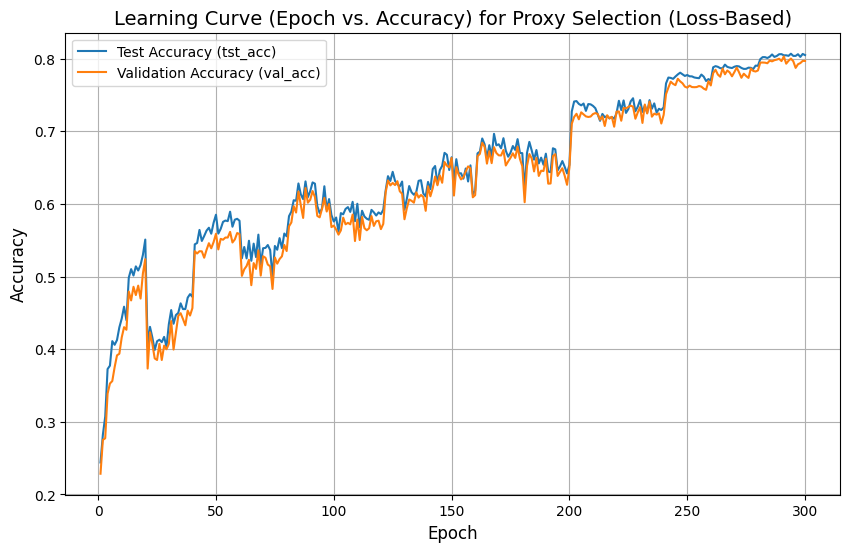

In [ ]:
import matplotlib.pyplot as plt

# Use the lists populated in Cell 23
epochs = range(1, len(tst_acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, tst_acc, label='Test Accuracy (tst_acc)')
plt.plot(epochs, val_acc, label='Validation Accuracy (val_acc)')

plt.title('Learning Curve (Epoch vs. Accuracy) for Proxy Selection (Loss-Based)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


Spike Plot (Cost per Epoch) Visualization

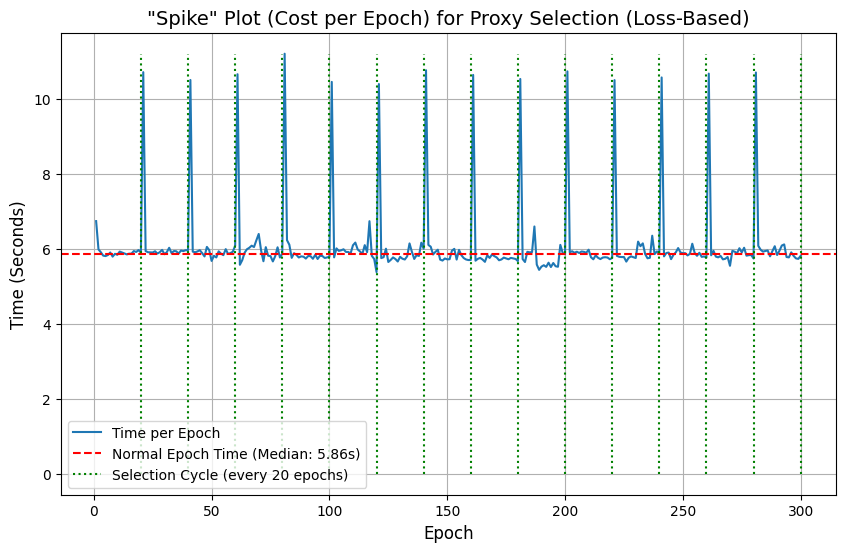

In [ ]:
import numpy as np

# Use the 'timing' list populated in Cell 23
epochs = range(1, len(timing) + 1)
select_every = dss_args.select_every  # This was defined as 20 in Cell 20
timing_np = np.array(timing)

# Compute the normal epoch duration (median)
base_time = np.median(timing_np)

plt.figure(figsize=(10, 6))
plt.plot(epochs, timing_np, label='Time per Epoch')
plt.axhline(y=base_time, color='red', linestyle='--', label=f'Normal Epoch Time (Median: {base_time:.2f}s)')

# Mark the selection epochs with vertical lines
selection_epochs = range(select_every, num_epochs + 1, select_every)
plt.vlines(x=selection_epochs, ymin=0, ymax=max(timing_np), color='green', linestyle=':', label=f'Selection Cycle (every {select_every} epochs)')

plt.title('"Spike" Plot (Cost per Epoch) for Proxy Selection (Loss-Based)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Time (Seconds)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


Cost vs. Accuracy (Trade-Off Plot) Visualization

Data loaded from results/emissions.csv


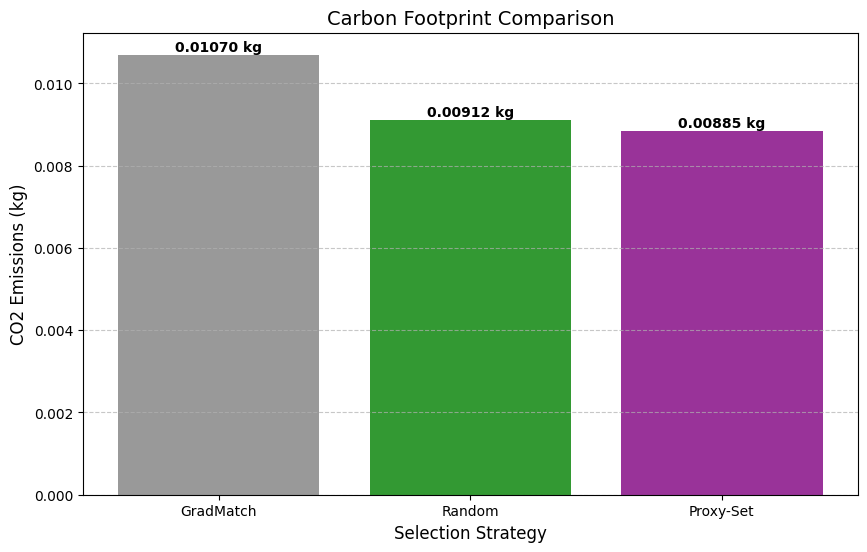

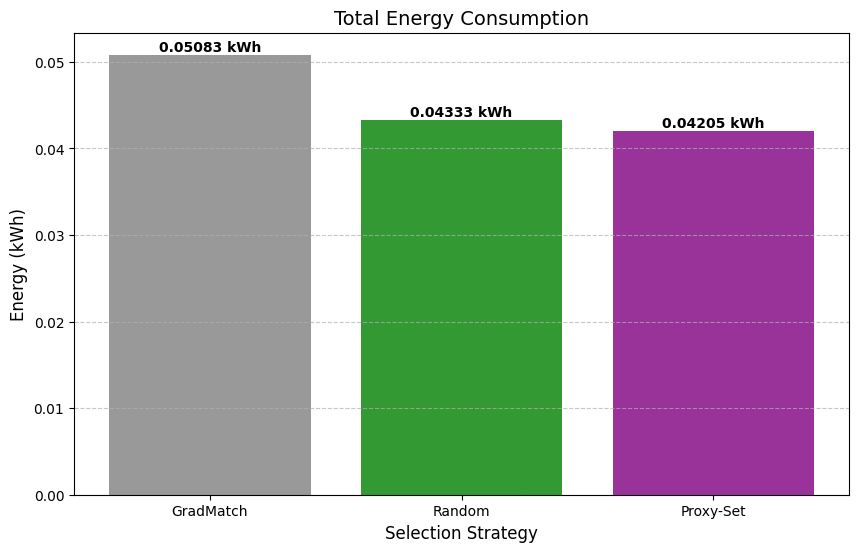

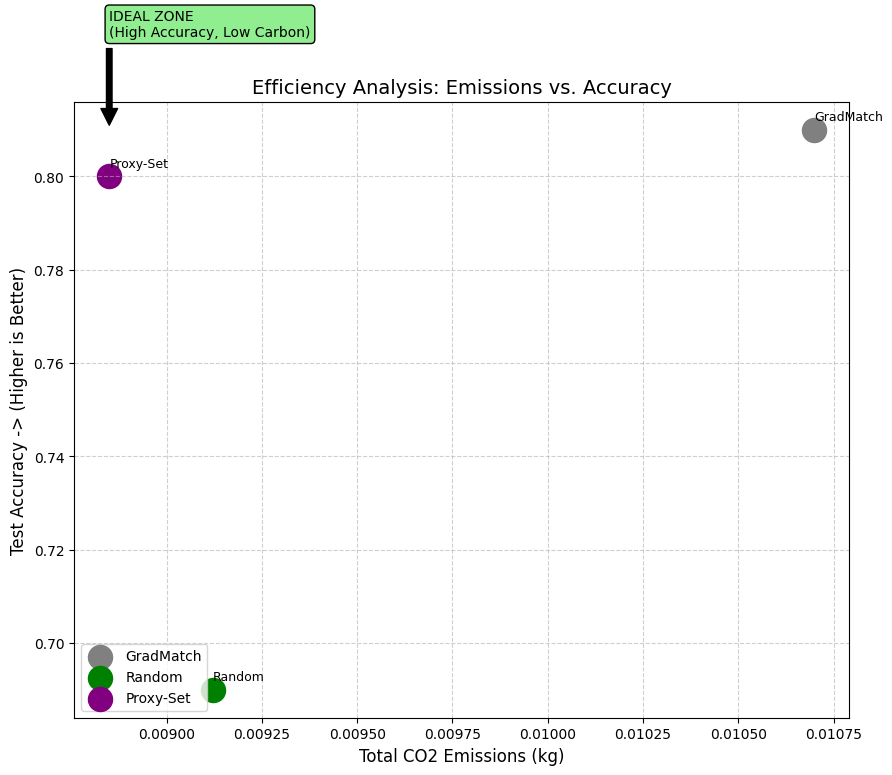

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# 1. Load Data from File
file_path = 'results/emissions.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"Data loaded from {file_path}")
else:
    print(f"Error: {file_path} not found! Please ensure the experiments have run.")
    # In case of error, we can proceed with an empty dataframe or sample data,
    # but since the file is required, we stop here.

# Clean names (remove EfficientSelection_ part)
df['short_name'] = df['project_name'].apply(lambda x: x.split('_')[1] if '_' in x else x)

# Colors
colors = ['gray', 'green', 'purple']

# --- GRAPH 1: Carbon Emissions (CO2) ---
plt.figure(figsize=(10, 6))
bars = plt.bar(df['short_name'], df['emissions'], color=colors, alpha=0.8)

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.5f} kg', ha='center', va='bottom', fontweight='bold')

plt.title('Carbon Footprint Comparison', fontsize=14)
plt.ylabel('CO2 Emissions (kg)', fontsize=12)
plt.xlabel('Selection Strategy', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- GRAPH 2: Energy Consumption (kWh) ---
plt.figure(figsize=(10, 6))
bars = plt.bar(df['short_name'], df['energy_consumed'], color=colors, alpha=0.8)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.5f} kWh', ha='center', va='bottom', fontweight='bold')

plt.title('Total Energy Consumption', fontsize=14)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.xlabel('Selection Strategy', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- GRAPH 3: Efficiency Trade-off ---
# Check accuracy values (add manually if not in CSV)
if 'final_test_accuracy' in df.columns:
    df['accuracy'] = df['final_test_accuracy']
else:
    # Manual values (Update if necessary)
    accuracies = {
        'Random': 0.69,
        'Glister': 0.81,
        'GradMatch': 0.81,
        'Proxy-Set': 0.80
    }
    df['accuracy'] = df['short_name'].map(accuracies)

plt.figure(figsize=(10, 8))

for i, row in df.iterrows():
    # Cycle colors (if rows exceed colors)
    color = colors[i % len(colors)]
    plt.scatter(row['emissions'], row['accuracy'], s=300, label=row['short_name'], color=color)
    plt.text(row['emissions'], row['accuracy'] + 0.002, f"{row['short_name']}", fontsize=9)

plt.title('Efficiency Analysis: Emissions vs. Accuracy', fontsize=14)
plt.xlabel('Total CO2 Emissions (kg)', fontsize=12)
plt.ylabel('Test Accuracy -> (Higher is Better)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show ideal zone
plt.annotate('IDEAL ZONE\n(High Accuracy, Low Carbon)', 
             xy=(df['emissions'].min(), df['accuracy'].max()), 
             xytext=(df['emissions'].min(), df['accuracy'].max() + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="black", lw=1))

plt.show()

Data loaded from results/emissions.csv


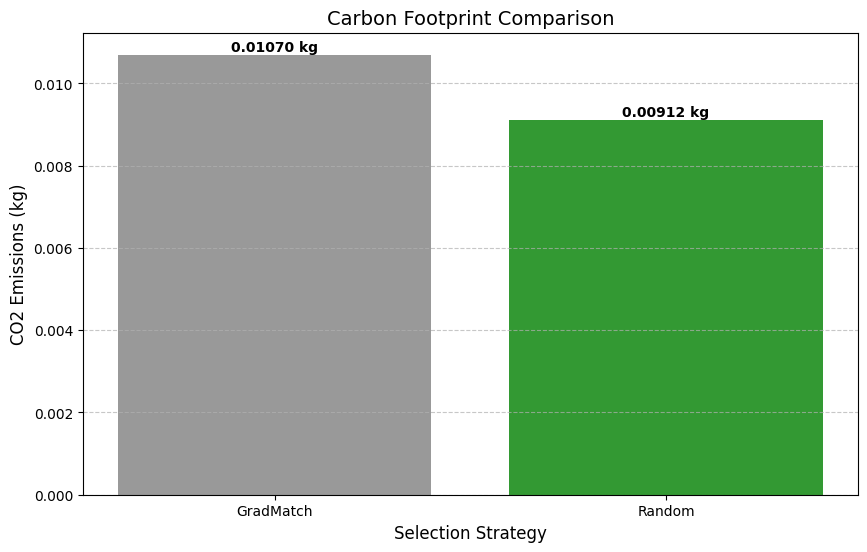

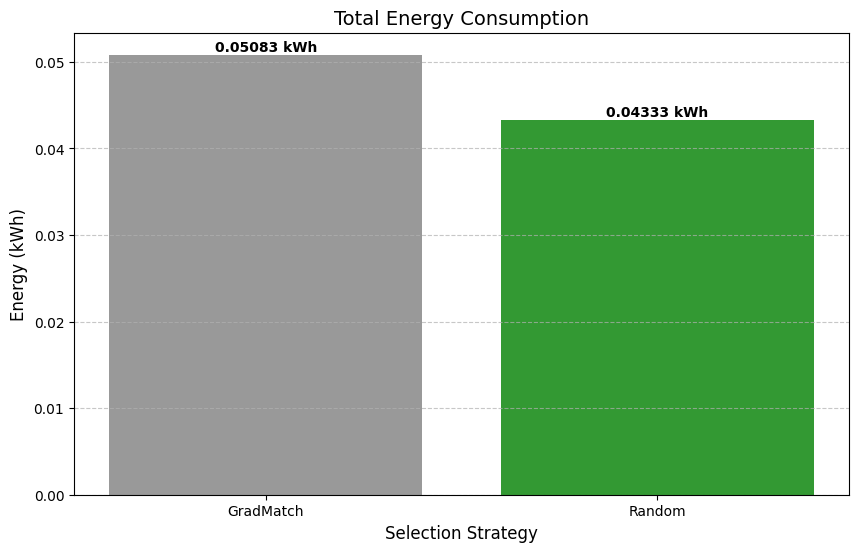

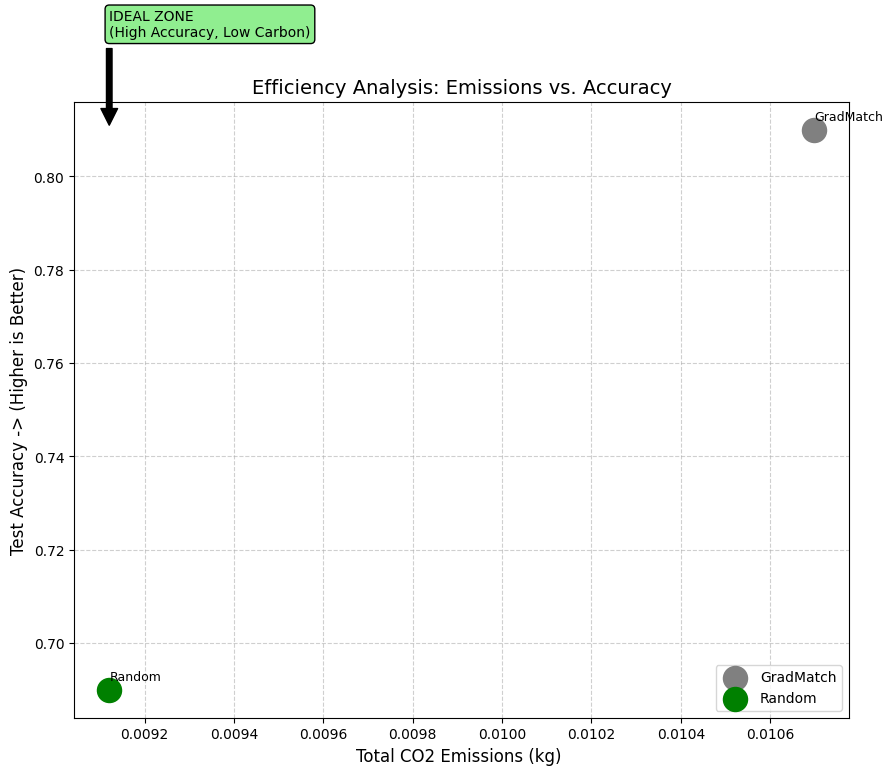

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# 1. Load Data from File
file_path = 'results/emissions.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"Data loaded from {file_path}")
else:
    print(f"Error: {file_path} not found! Please ensure the experiments have run.")
    # In case of error, we can proceed with an empty dataframe or sample data,
    # but since the file is required, we stop here.

# Clean names (remove EfficientSelection_ part)
df['short_name'] = df['project_name'].apply(lambda x: x.split('_')[1] if '_' in x else x)

# Colors
colors = ['gray', 'green', 'purple']

# --- GRAPH 1: Carbon Emissions (CO2) ---
plt.figure(figsize=(10, 6))
bars = plt.bar(df['short_name'], df['emissions'], color=colors, alpha=0.8)

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.5f} kg', ha='center', va='bottom', fontweight='bold')

plt.title('Carbon Footprint Comparison', fontsize=14)
plt.ylabel('CO2 Emissions (kg)', fontsize=12)
plt.xlabel('Selection Strategy', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- GRAPH 2: Energy Consumption (kWh) ---
plt.figure(figsize=(10, 6))
bars = plt.bar(df['short_name'], df['energy_consumed'], color=colors, alpha=0.8)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.5f} kWh', ha='center', va='bottom', fontweight='bold')

plt.title('Total Energy Consumption', fontsize=14)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.xlabel('Selection Strategy', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- GRAPH 3: Efficiency Trade-off ---
# Check accuracy values (add manually if not in CSV)
if 'final_test_accuracy' in df.columns:
    df['accuracy'] = df['final_test_accuracy']
else:
    # Manual values (Update if necessary)
    accuracies = {
        'Random': 0.69,
        'Glister': 0.81,
        'GradMatch': 0.81,
        'Proxy-Set': 0.80
    }
    df['accuracy'] = df['short_name'].map(accuracies)

plt.figure(figsize=(10, 8))

for i, row in df.iterrows():
    # Cycle colors (if rows exceed colors)
    color = colors[i % len(colors)]
    plt.scatter(row['emissions'], row['accuracy'], s=300, label=row['short_name'], color=color)
    plt.text(row['emissions'], row['accuracy'] + 0.002, f"{row['short_name']}", fontsize=9)

plt.title('Efficiency Analysis: Emissions vs. Accuracy', fontsize=14)
plt.xlabel('Total CO2 Emissions (kg) ', fontsize=12)
plt.ylabel('Test Accuracy -> (Higher is Better)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show ideal zone
plt.annotate('IDEAL ZONE\n(High Accuracy, Low Carbon)', 
             xy=(df['emissions'].min(), df['accuracy'].max()), 
             xytext=(df['emissions'].min(), df['accuracy'].max() + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="black", lw=1))

plt.show()